# Lab Assignment Seven: Wide and Deep Network Architectures 

$$ Team Member Names: Rongxiao Huang, Zeen Liu, Hua Zong $$

______
<a id="top"></a>
## Contents
* <a href="#BD">1. Business Understanding and Data Preparation</a>
* <a href="#MO">2. Modeling</a>
* <a href="#EX">3. Importance Exploration of Cross-product Features </a>
* <a href="#RE">Reference</a>

___
<a id="BD"></a>
<a href="#top">Back to Top</a>
## 1. Business Understanding and Data Preparation

### 1.1 Business Understanding

**Dataset:** The Chile data frame has 2700 rows and 8 columns. The data are from a national survey conducted in April and May of 1988 by FLACSO/Chile.                    https://vincentarelbundock.github.io/Rdatasets/doc/car/Chile.html


According to the Wikipedia, the 1988 Chilean national plebiscite was a national referendum held on 5 October 1988 to determine whether Chile's President, Augusto Pinochet, should extend his rule for another eight years. And the candidate was to be ratified by registered voters in a national plebiscite. This data set is a part of the natioanl survey on the registered voters in 1988.

Though the voting back to the late 1980s, the model would still help some Chlian Political Science researchers and scholars in the related field. As the Wikipiedia states, the dictatorship ending is attributed to the pressure from business and unease with Pinochet's rule. The model would help us to see how was the social economic status behind the voters who voted "Yes", "No", "Undecided", or even "Abstain" in the Aprial and May of 1988, two quarters before the final voting. Especially in the undecided class, which were over 20% of the given sample, researchers would like to know how this group would act in the final voting and how the last-five-month campaign affected the undecided group in the registered voters.

Besides, The political parties endorsed the votings would be interested in the models as well. Through the model, the political parties related in this voting would also see social economic status from the surveyed voters. Therefore, the parties could have know what groups of people they should work on to earn more votes for their own camps. 



### 1.2. Data Pre-processing

** The class variable: vote (voting status) ** -- A factor with levels: `A`, will abstain; `N`, will vote no (against Pinochet); `U`, undecided; `Y`, will vote yes (for Pinochet).

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. load the chile-voting dataset
df = pd.read_csv('C:/Users/zeen/Desktop/lason/lab 4/Chile.csv')

# 2. delete the fist column, which refers to index
del df['Unnamed: 0']

# 3. create numrical indicator for education level
#    It was a factor with levels (note: out of order in the original dataset): 
#    P, Primary; PS, Post-secondary; S, Secondary. 
df['edu_num'] = df.education.replace(to_replace = ['P', 'S', 'PS'],
                 value = range(3))
#    convert sex to numrical indicator
#    A factor with levels: F, female; M, male. 
df['sex_onehot'] = df.sex.replace(to_replace = ['F', 'M'],
                 value = range(2))
#    perform one-hot encoding of the categorical data "region"

# 5. impute some missing values, grouped by their 
#    region, population, sex and education
df_grouped = df.groupby(by=['region','population','sex_onehot','education'])
#    now use this grouping to fill the data set in each group, 
#    then transform back fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median())) 
#    fillin the grouped variables and vote from original data frame
df_imputed[['region','population','sex_onehot','education','vote']] = df[['region','population','sex_onehot','education','vote']]

# 6. scale 'population','age','income'
norm_features = ['population','age','income']
df_imputed[norm_features] = (df_imputed[norm_features]-df_imputed[norm_features].mean()) / df_imputed[norm_features].std()

# 7. rearrange the columns
df_imputed = df_imputed[['region','population','sex_onehot','education','age','income','statusquo','vote']]


tmp_df = pd.get_dummies(df_imputed.region,prefix='region')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

There are some missing data in the columns: `age, education, income, statusquo`, and `vote.`

We decided to delete the rows with missing value in `vote`, because it is the class variable we would like to predict. However, we stored these instances into another object, of which the instance would be predicted as a certain class by implementing our models.

We also agreed to delete the rows with missing value in the column of `education`, because we planned to impute the missing values in `income` and `statusquo` by using groups' medians according to `region, population, sex` and `education`.

In [2]:
# 4. impute some missing values, grouped by their 
#    region, population, sex and education
df_grouped = df.groupby(by=['region','population','sex','education'])
#    now use this grouping to fill the data set in each group, 
#    then transform back fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median())) 
#    fillin the grouped variables and vote from original data frame
df_imputed[['region','population','sex','education','vote']] = df[['region','population','sex','education','vote']]

We should then check whether duplicate data exists.

Through the duplicates check, it shows there are 9 duplicated observations in the dataset. We decided to keep these in the dataset because we don't have obivious evidence to prove it's true duplicates since no ID information showed in the dataset.

In [3]:
# 5. find the duplicate instances
idx = df_imputed.duplicated()
df_imputed[idx] # list the instances which are not the first-show

,age,income,statusquo,edu_num,sex_onehot,region_C,region_M,region_N,region_S,region_SA,region,population,sex,education,vote
1996,43.0,7500.0,-1.29617,0.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,P,N
2172,24.0,7500.0,-1.29617,1.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,S,N
2246,24.0,35000.0,-1.29617,2.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,PS,N
2269,27.0,15000.0,-1.29617,1.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,S,N
2272,23.0,35000.0,-1.29617,2.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,PS,N
2296,20.0,35000.0,-1.29617,1.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,S,N
2401,20.0,35000.0,-1.25795,1.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,S,N
2468,26.0,125000.0,-1.21834,2.0,0,0.0,0.0,0.0,0.0,1.0,SA,250000,F,PS,N
2495,23.0,15000.0,-1.29617,1.0,1,0.0,0.0,0.0,0.0,1.0,SA,250000,M,S,N


In [4]:
from copy import deepcopy

# 6. delete rows with missing value
df_imputed.dropna(inplace=True)
df_train = deepcopy(df_imputed) # copy the data

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 8. encode the categorical features as integers (later on we will encode one hot)
encoders = dict() 
categorical_headers = ['region','sex','education']

for col in categorical_headers+['vote']:
    df_train[col] = df_train[col].str.strip()
    
    if col=="vote":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])

# 9. scale all the continuous data
numeric_headers = ["age", "population", "edu_num", "income", "statusquo"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))

In [6]:
# 10. create a feature indicating income group
income_grp=[]
for inc in df_train.income:
    if inc < -0.5:
        grp = 'low income'
    elif inc >= -0.5 and inc < 0.5:
        grp = 'average income'
    else:
        grp = 'high income'
    
    income_grp.append(grp)
    
for grp in set(income_grp):
    print(grp, sum([x == grp for x in income_grp]))
    
df_train['income_grp'] = income_grp # append the list to the data frame

encoders['income_grp'] = LabelEncoder() # encode the feature
df_train['income_grp'+'_int'] = encoders['income_grp'].fit_transform(df_train['income_grp'])

categorical_headers.append('income_grp') # update categorical_headers

high income 415
low income 623
average income 1484


** Final Dataset Description **

|Variable | description| scale|
|----|--------|-----|
|age: |age of respondent (continuous)| ratio|
|income:      |monthly income (continuous)| ratio|
|statusquo:      |scale of support for the status-quo (continuous)| ratio|
|edu_num:  |education level of respondent (continuous)| ordinal|
|population: |population size of respondent's community (continuous)| ratio|
|vote:     |A:will abstain, N:will vote against Pinochet, U:undecided, Y:will vote for Pinochet| nominal|
|region:   |Central Region, Metropolitan Santiago Area, Northern Region, Southern Region, City of Santiago| nominal|
|education:           |education level of respondent: Primary, Secondary, Post-secondary| nominal|
|sex:            |sex of respondent: Female, Male| nominal|
|income_grp:     |income group: Low Income, Average Income, High Income| nominal|

** Note: ** It would be better to incorporate the data pre-poccessing into the stages in Pipeline. However, here we scaled and imputed the data at the beginning. It might compromise our results without building the pipeline. But we will aviod the data snooping problem in post-processing part by implementing the cross validation technique.

### 1.3 Cross-product Features

We later created a linear classifier that takes the categorical features as input and makes six sets of crossed columns shown as below. Because femals and males with different education levels had different opinions in different regions, the interaction terms `region X sex`, `region X eduction`, as well as `education X sex`, were incorporated. In addition, people from the different income groups and with different education levels may have different opinions towards the voting, the interaction term `education X income_grp` was created. For the similar reason, the interaction term `region X income_grp` was also added.

In [7]:
print("categorical features:\n", categorical_headers)
print("crossed column:", 
      "\n     [('region', 'sex'),('region', 'education'),('sex', 'education'),\
                            \n     ('region', 'income_grp'), ('education', 'income_grp')")

categorical features:
 ['region', 'sex', 'education', 'income_grp']
crossed column: 
     [('region', 'sex'),('region', 'education'),('sex', 'education'),                            
     ('region', 'income_grp'), ('education', 'income_grp')


### 1.4 Evaluation Metric

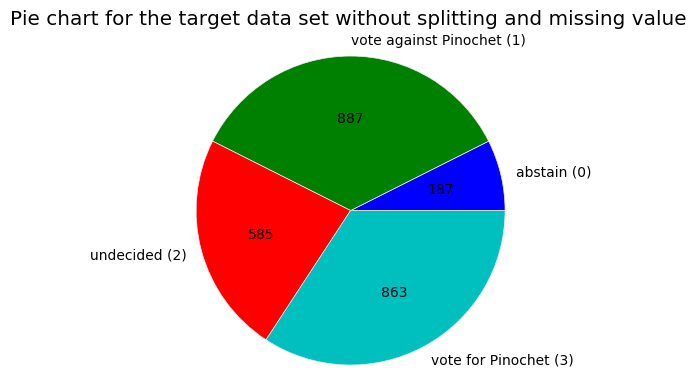

Number of instances in the binary classification problem: 2522


In [8]:
from sklearn.metrics import make_scorer,f1_score
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# plot a pie chart of classes
labels = "abstain (0)", "vote against Pinochet (1)", "undecided (2)", "vote for Pinochet (3)"
vote = df_train['vote']
sizes = [sum(vote == 0), sum(vote == 1), sum(vote == 2), sum(vote == 3)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(vote) / 100))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart for the target data set without splitting and missing value', y=1.08)
plt.show()

print('Number of instances in the binary classification problem:', len(vote))

Because the target's class sizes are extremely unbalanced, we should use other evaluation metric instead of accuracy, which evaluates the true negatives equally with the true positives. However, we care more about whether the algorithm correctly classfied a particular class, **therefore the F1 score was chosen for our scorer**, which is an average evaluation of the precision and the recall.

There are two methods by which you can get such average statistic of information retrieval and classification.
In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics; In Macro-average method, you just take the average of the F1 score of the system on different sets. 

Suitability macro-average method, which weights all classes equally, can be used when you want to know how the system performs overall across the sets of data. On the other hand, micro-average method, which weights all instances equally, can be a useful measure when your dataset varies in size. **Here we chosen micro-average method because we have different class sizes.**

** To sum up, we decided to use micro-average F1 score as our evaluation scorer. **

http://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001 

In [9]:
from sklearn.metrics import make_scorer,f1_score

# make f1 micro our scorer
scorer = make_scorer(f1_score, average='micro', pos_label=1, greater_is_better = True)

### 1.5 Data Splitting

We planned to do cross validation (stratified sampling) on the train set, and then evaluate the performance of the model by looking into the validation scores. Therefore, we created 10 pairs of train sets and test sets by stratifiedly splitting the data according to the classes in vote. The validation score provides the performance of the model on external data, therefore it is useful information free from data snooping. In comparing the performance of different deep network architectures to obtain our best model, we calculated the pair-metric differences and its corresponding confidence interval.

We also want to compare the performance of our best wide and deep network to a standard multi-layer perceptron (MLP) by using the receiver operating characteristic and area under the curve. The evaluation result from each fold genearlly gives us an overall idea about the performace of each model when we conduct the model comparison.

In [10]:
from sklearn.cross_validation import StratifiedKFold

df_train.reset_index(inplace=True)
# split our data into train and test sets 
# shuffle-split 10 times
K = 10
kfold = StratifiedKFold(y=df_train['vote'].values, n_folds=K, random_state=1)

C:\Users\zeen\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


___
<a id="MO"></a>
<a href="#top">Back to Top</a>
## 2. Modeling

### 2.1 A Wide and Deep Network 

In [11]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

# create function to return tensor input for the estimator 
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.constant(df[k].values) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [12]:
import itertools

# update the model to take input features as a dictionary
def setup_wide_deep_columns(num_cross = 6, sel_feature = 'region', mode = 'all', cross_ind = 1):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
    
    if mode == 'num':                   # define mode for number of features
        com = list(itertools.combinations(categorical_headers,2))
        com_ind = np.array(np.random.choice(6, num_cross, replace=False))
        com_list = [com[i] for i in com_ind]
        
    elif mode == 'feature':             # define mode for selecting features
        cata_list = set(categorical_headers)
        com_full = list(itertools.combinations(cata_list,2))
        cata_list.remove(sel_feature)
        com_del = list(itertools.combinations(cata_list,2))
        com_list = [n for n in com_full if n not in com_del]
    
    elif mode == 'all':                 # mode for all cross-product features
        com_list = [('region','sex'),('region', 'education'), ('education', 'sex'),
                    ('region', 'income_grp'), ('education', 'income_grp'),('income_grp','sex')]
        
    elif mode == 'one':                 # mode for just one cross-product feature
        com_list = [('region','sex'),('region', 'education'), ('education', 'sex'),
                    ('region', 'income_grp'), ('education', 'income_grp'),('income_grp','sex')]
        com_list = com_list[cross_ind]
        
    # also add in some specific crossed columns
    cross_columns = com_list
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
         
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [13]:
# ignore all the deprecations that the learn API needs to deal with... ugh
tf.logging.set_verbosity(tf.logging.ERROR)

# set up the wide and deep columns
wide_columns, deep_columns = setup_wide_deep_columns(mode='all')

clf_wd1 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd2 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50, 30],
                        n_classes=4)

### 2.2 Evaluation of Deep Network Architectures

In [14]:
%%time

# calculate f1 scores for both networks
clf_wd1_f1 = []
clf_wd2_f1 = []
wd1_proba = []
wd2_proba = []

for k, (train, test) in enumerate(kfold):
    
    input_wrapper = lambda:process_input(df_train.iloc[train],'vote',categorical_headers, numeric_headers)
    output_wrapper = lambda:process_input(df_train.iloc[test],None,categorical_headers, numeric_headers)

    clf_wd1.fit(input_fn=input_wrapper, steps=1000)
    clf_wd2.fit(input_fn=input_wrapper, steps=1000)

    yhat1 = clf_wd1.predict(input_fn=output_wrapper)
    yhat2 = clf_wd2.predict(input_fn=output_wrapper)
    proba_wd1 = clf_wd1.predict_proba(input_fn=output_wrapper)
    proba_wd2 = clf_wd2.predict_proba(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    y_hat_1 = [x for x in yhat1]
    y_hat_2 = [x for x in yhat2]
    y_test = list(df_train.iloc[test].vote.values)
    
    proba_wd1 = [x for x in proba_wd1]
    proba_wd1 = np.vstack(proba_wd1)
    proba_wd2 = [x for x in proba_wd2]
    proba_wd2 = np.vstack(proba_wd2)
    
    external_f1_1 = f1_score(y_test, y_hat_1, average='micro')
    external_f1_2 = f1_score(y_test, y_hat_2, average='micro')
    
    clf_wd1_f1.append(external_f1_1)
    clf_wd2_f1.append(external_f1_2)
    wd1_proba.append(proba_wd1)
    wd2_proba.append(proba_wd2)

Wall time: 12min 22s


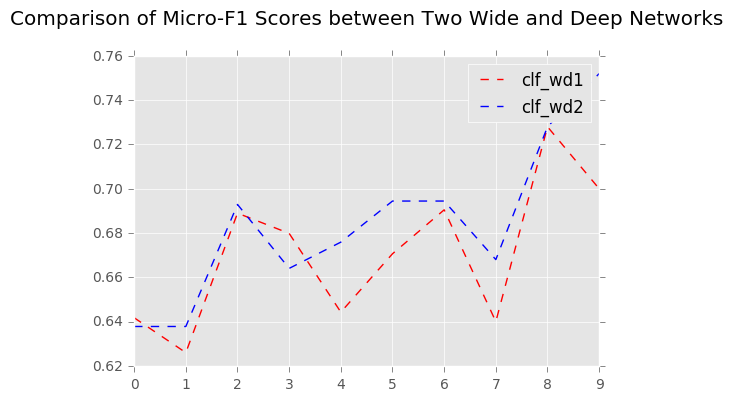

The fisrt Wide and Deep Learning has an average f1 score of 0.670991469643
The second Wide and Deep Learning has an average f1 score of 0.684531377451


In [15]:
import matplotlib.pyplot as plt

# plot the f1 scors for two networks
ax1=plt.plot(clf_wd1_f1, 'r--',label = 'clf_wd1')
ax2=plt.plot(clf_wd2_f1 , 'b--',label = 'clf_wd2')
plt.legend(loc="upper right")
plt.title('Comparison of Micro-F1 Scores between Two Wide and Deep Networks',
         y=1.08)
plt.show()

print("The fisrt Wide and Deep Learning has an average f1 score of", np.mean(clf_wd1_f1))
print("The second Wide and Deep Learning has an average f1 score of", np.mean(clf_wd2_f1))

From the plot above, we can see that our second Wide and Deep Learning is slight better than the first one. Therefore, our second learning would be used to compare with standard Multiple Layer Perceptron.

** The model clf_wd2 is better in terms of micro-f1 score.**

### 2.3 Comparison of Our Best Wide and Deep Network and a Standard MLP

In [16]:
# create standard MLP
features_tf = [layers.real_valued_column('', dimension=9)]

mlp = learn.DNNClassifier(hidden_units=[50, 30], 
                            feature_columns=features_tf,
                            activation_fn=tf.nn.relu, 
                            # tf.tanh, tf.sigmoid, tf.nn.relu, tf.nn.softmax etc.
                            n_classes=4)

mlp_features = numeric_headers + ['sex_onehot', 'region_C', 'region_M', 'region_N', 'region_S', 'region_SA']

# fit and calculate f1 scores
mlp_f1 = []
mlp_proba = []
for k, (train, test) in enumerate(kfold):

    df_tr = df_train.iloc[train]
    df_te = df_train.iloc[test]

    mlp.fit(df_tr[mlp_features].values, df_tr['vote'].values ,steps=1000)
    
    yhat = mlp.predict(df_te[mlp_features].values)
    proba_mlp = mlp.predict_proba(df_te[mlp_features].values)
    
    y_hat = [x for x in yhat]
    proba_mlp = [x for x in proba_mlp]
    proba_mlp = np.vstack(proba_mlp)
    
    y_test = df_te.vote.values
    
    external_f1 = f1_score(y_test, y_hat, average='micro')
    
    
    mlp_f1.append(external_f1)
    mlp_proba.append(proba_mlp)

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, auc
from scipy import interp

nclass = df_train.vote.unique()

def roc_clf(proba_=mlp_proba):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    for i, (train, test) in enumerate(kfold):
        df_tr = df_train.iloc[train]
        df_te = df_train.iloc[test]
        y_train = df_tr.vote.values
        y_test = df_te.vote.values
        
        perclass_mean_tpr = 0.0
        roc_auc = 0
        classes = np.unique(y_train)
        
        probas = proba_[i]
        
        for j in classes:
            fpr, tpr, thresholds = roc_curve(y_test,
                                         probas[:, j],
                                         pos_label=j)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0
            roc_auc += auc(fpr, tpr)
        
        perclass_mean_tpr /= len(classes)
        mean_tpr += perclass_mean_tpr
        roc_auc /= len(classes)
        plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
    mean_tpr /= 10
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
    plt.legend(loc='best')
    plt.grid()

The fisrt Wide and Deep Learning has an average score of 0.663476459316
Our best Wide and Deep Learning has an average f1 score of 0.684531377451


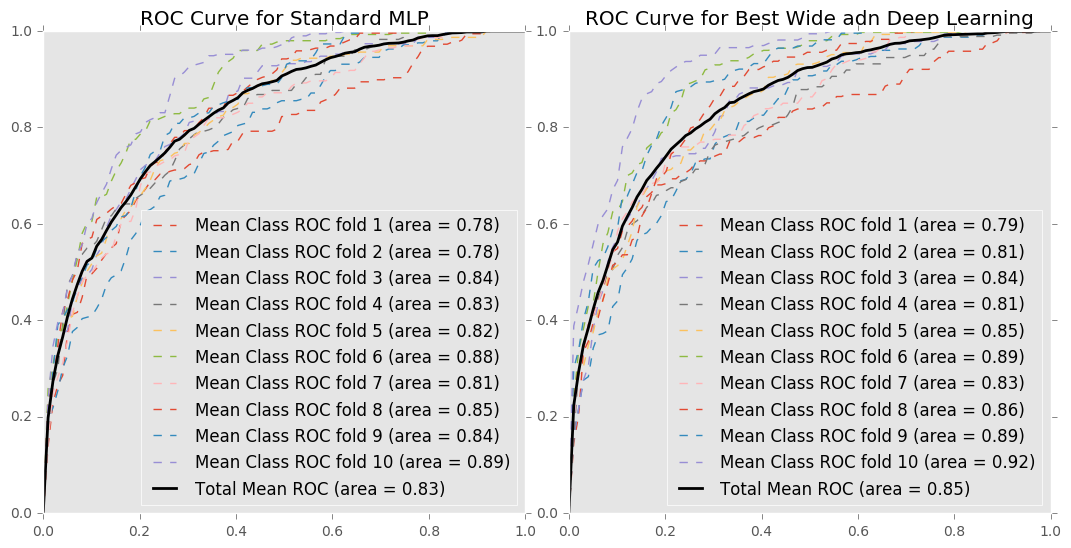

In [18]:
plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
ax1 = plt.title("ROC Curve for Standard MLP")
roc_1 = roc_clf(mlp_proba)
ax2 = plt.subplot(gs[:2, -2:])
ax2 = plt.title("ROC Curve for Best Wide adn Deep Learning")
roc_2 = roc_clf(wd2_proba)

print("The fisrt Wide and Deep Learning has an average score of", np.mean(mlp_f1))
print("Our best Wide and Deep Learning has an average f1 score of", np.mean(clf_wd2_f1))

From the two ROC curves betweeen standard MLP and our best Wide and Deep Learning, it has visually evidence that the right side has the curve comparatively closer to the upper-left corner overall. And from the Total Mean of the Area under the Curve is also higher on the right side, which is 0.85. And the AUC in standard MLP is about 0.83. The result is kind of matching our expectation that the Wide and Deep Learning should perform better than normal MLP.

Besides, the result of standard MLP thorugh DNNClassifier in tensorflow is also better than the normal MLP we had in previous projects. The bagging ensemble has the AUC about 0.73 from the previous project.

___
<a id="EX"></a>
<a href="#top">Back to Top</a>
## 3. Importance Exploration of Cross-product Features

### 3.1 Check the importance of Cross-product Features

**To investigate which cross-product feature is the most important, we added one cross-product feature each time from the cross_list below. Through this way, we expected to see the difference on the total mean of the AUC between each model with only one cross-product feature. If there were one corss-product feature having a significant higher AUC values compared to the others, it implied that specific cross-product feature is more importance than others. And this is our inituial idea to investigate the importance.**

In [19]:
cross_list = [('region','sex'),('region', 'education'), ('education', 'sex'),
                    ('region', 'income_grp'), ('education', 'income_grp'),('income_grp','sex')] #set up list

In [20]:
wide_columns_c1, deep_columns_c1 = setup_wide_deep_columns(mode='all', cross_ind = 1)      #add cross-product feature
wide_columns_c2, deep_columns_c2 = setup_wide_deep_columns(mode='all', cross_ind = 2)
wide_columns_c3, deep_columns_c3 = setup_wide_deep_columns(mode='all', cross_ind = 3)
wide_columns_c4, deep_columns_c4 = setup_wide_deep_columns(mode='all', cross_ind = 4)
wide_columns_c5, deep_columns_c5 = setup_wide_deep_columns(mode='all', cross_ind = 5)
wide_columns_c6, deep_columns_c6 = setup_wide_deep_columns(mode='all', cross_ind = 6)

clf_cross1 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c1,
                        dnn_feature_columns=deep_columns_c1,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_cross2 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c2,
                        dnn_feature_columns=deep_columns_c2,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_cross3 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c3,
                        dnn_feature_columns=deep_columns_c3,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_cross4 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c4,
                        dnn_feature_columns=deep_columns_c4,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_cross5 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c5,
                        dnn_feature_columns=deep_columns_c5,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_cross6 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_c6,
                        dnn_feature_columns=deep_columns_c6,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

In [21]:
%%time

# calculate f1 scores for both networks
clf_cross1_f1 = []
clf_cross2_f1 = []
clf_cross3_f1 = []
clf_cross4_f1 = []
clf_cross5_f1 = []
clf_cross6_f1 = []
cross1_proba = []
cross2_proba = []
cross3_proba = []
cross4_proba = []
cross5_proba = []
cross6_proba = []

for k, (train, test) in enumerate(kfold):
    
    input_wrapper = lambda:process_input(df_train.iloc[train],'vote',categorical_headers, numeric_headers)
    output_wrapper = lambda:process_input(df_train.iloc[test],None,categorical_headers, numeric_headers)

    clf_cross1.fit(input_fn=input_wrapper, steps=50)
    clf_cross2.fit(input_fn=input_wrapper, steps=50)
    clf_cross3.fit(input_fn=input_wrapper, steps=50)
    clf_cross4.fit(input_fn=input_wrapper, steps=50)
    clf_cross5.fit(input_fn=input_wrapper, steps=50)
    clf_cross6.fit(input_fn=input_wrapper, steps=50)
    

    yhat1 = clf_cross1.predict(input_fn=output_wrapper)
    yhat2 = clf_cross2.predict(input_fn=output_wrapper)
    yhat3 = clf_cross3.predict(input_fn=output_wrapper)
    yhat4 = clf_cross4.predict(input_fn=output_wrapper)
    yhat5 = clf_cross5.predict(input_fn=output_wrapper)
    yhat6 = clf_cross6.predict(input_fn=output_wrapper)
    
    proba_cross1 = clf_cross1.predict_proba(input_fn=output_wrapper)
    proba_cross2 = clf_cross2.predict_proba(input_fn=output_wrapper)
    proba_cross3 = clf_cross3.predict_proba(input_fn=output_wrapper)
    proba_cross4 = clf_cross4.predict_proba(input_fn=output_wrapper)
    proba_cross5 = clf_cross5.predict_proba(input_fn=output_wrapper)
    proba_cross6 = clf_cross6.predict_proba(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    y_hat_1 = [x for x in yhat1]
    y_hat_2 = [x for x in yhat2]
    y_hat_3 = [x for x in yhat3]
    y_hat_4 = [x for x in yhat4]
    y_hat_5 = [x for x in yhat5]
    y_hat_6 = [x for x in yhat6]
    
    y_test = list(df_train.iloc[test].vote.values)
    
    proba_cross1 = [x for x in proba_cross1]
    proba_cross1 = np.vstack(proba_cross1)
    proba_cross2 = [x for x in proba_cross2]
    proba_cross2 = np.vstack(proba_cross2)
    proba_cross3 = [x for x in proba_cross3]
    proba_cross3 = np.vstack(proba_cross3)
    proba_cross4 = [x for x in proba_cross4]
    proba_cross4 = np.vstack(proba_cross4)
    proba_cross5 = [x for x in proba_cross5]
    proba_cross5 = np.vstack(proba_cross5)
    proba_cross6 = [x for x in proba_cross6]
    proba_cross6 = np.vstack(proba_cross6)
    
    external_f1_1 = f1_score(y_test, y_hat_1, average='micro')
    external_f1_2 = f1_score(y_test, y_hat_2, average='micro')
    external_f1_3 = f1_score(y_test, y_hat_3, average='micro')
    external_f1_4 = f1_score(y_test, y_hat_4, average='micro')
    external_f1_5 = f1_score(y_test, y_hat_5, average='micro')
    external_f1_6 = f1_score(y_test, y_hat_6, average='micro')
    
    clf_cross1_f1.append(external_f1_1)
    clf_cross2_f1.append(external_f1_2)
    clf_cross3_f1.append(external_f1_3)
    clf_cross4_f1.append(external_f1_4)
    clf_cross5_f1.append(external_f1_5)
    clf_cross6_f1.append(external_f1_6)
    
    cross1_proba.append(proba_cross1)
    cross2_proba.append(proba_cross2)
    cross3_proba.append(proba_cross3)
    cross4_proba.append(proba_cross4)
    cross5_proba.append(proba_cross5)
    cross6_proba.append(proba_cross6)
    

Wall time: 20min 56s


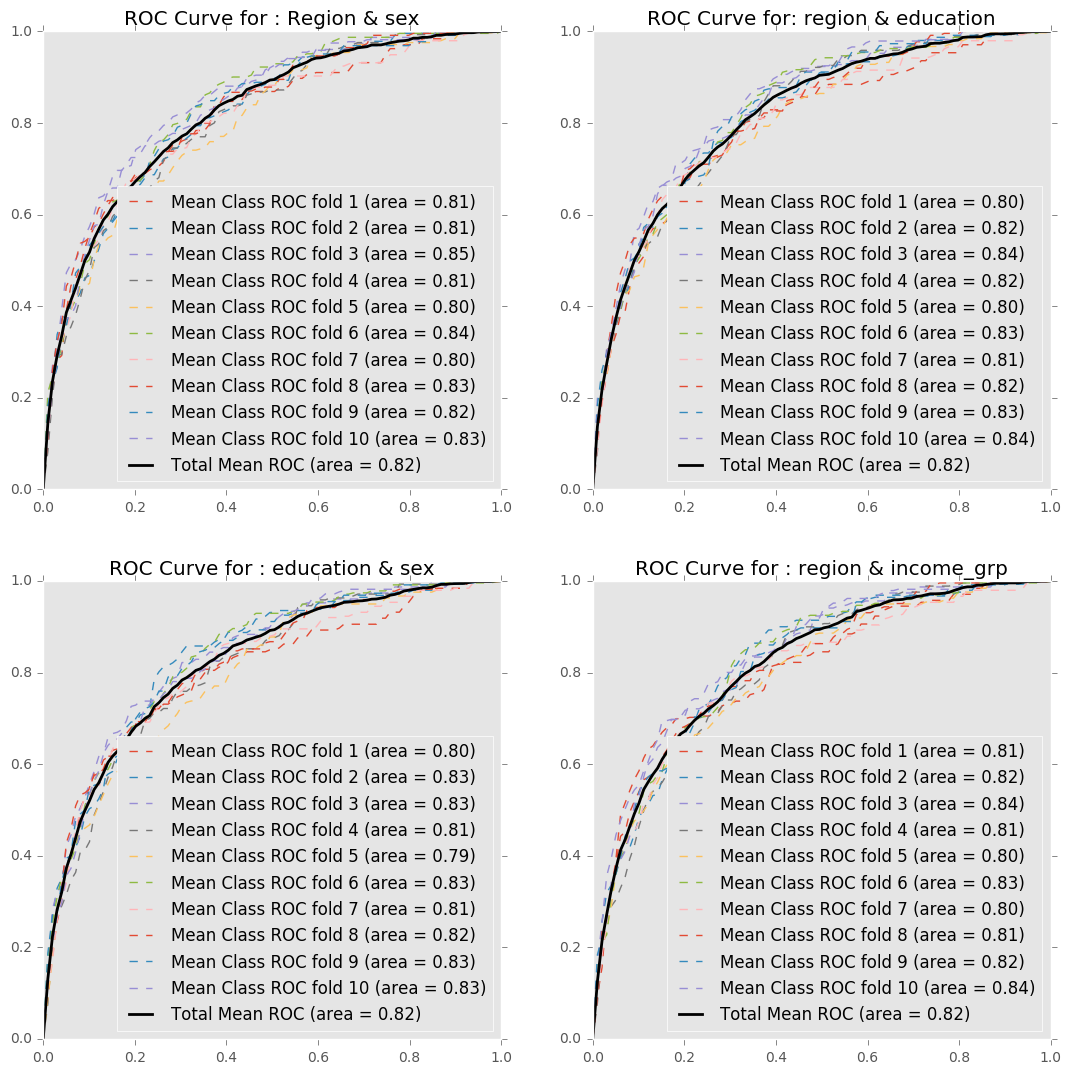

In [22]:

plt.figure(figsize=(13, 13))

gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,1],
                       height_ratios=[1,1]
                       )


ax1 = plt.subplot(gs[0])
ax1 = plt.title("ROC Curve for : Region & sex")
roc_1 = roc_clf(proba_=cross1_proba)

ax2 = plt.subplot(gs[1])
ax2 = plt.title("ROC Curve for: region & education")
roc_2 = roc_clf(proba_=cross2_proba)

ax3 = plt.subplot(gs[2])
ax3 = plt.title("ROC Curve for : education & sex")
roc_3 = roc_clf(proba_=cross3_proba)

ax4 = plt.subplot(gs[3])
ax4 = plt.title("ROC Curve for : region & income_grp")
roc_4 = roc_clf(proba_=cross4_proba)


**Actually, the all six ROC plots from the Wide and Deep Learning models including only cross-feature product gave us similar Total Mean AUC, which were about 0.82. And we selected four ROC plots to display here ("region & sex", "region & education", "education & sex",and "region & income_grp").** 

**From the common sense, we think these four cross-product could have been the importance, especially the region with others. The selection in the United States also varies a lot state by state and that's why we have some nick names liek deep blue/red states. And same issue could also happen in Chile. Also, "education & sex" is another cross-product we initially thought could have been affected the result significantly. And the above statement is the reason why we showed thses four ROCs here. Unfortuantley, the conclusion is that none of these cross-product shows very significant influence to the final performance. **

### 3.2 Some idea on importance of cross-product

### 3.2.1 How to find important cross-product features

**To further investigate the importance of the cross-product features, we came with some other possile solutions to see which one could be the most significant. In some data set, we may have a lot more catagorical variables, so it's pretty difficult to check all the cross-product features one by one. **

**One idea is to randomly select a catagorical variable, check all the cross-product features with that specific variable, and choose the cross-product which will give us the lowest MSE(or other cost function) and add it into the model. Then we choose the other variable in that cross-product feature as the new variable we look at, and continuing on searching the cross-product features.(similar as stochastic gradient descent method).**

Below is some output:

In [24]:

wide_columns_region, deep_columns_region = setup_wide_deep_columns(sel_feature = 'region', mode = 'feature')
wide_columns_sex, deep_columns_sex = setup_wide_deep_columns(sel_feature = 'sex', mode = 'feature')
wide_columns_education, deep_columns_education = setup_wide_deep_columns(sel_feature = 'education', mode = 'feature')
wide_columns_income_grp, deep_columns_income_grp = setup_wide_deep_columns(sel_feature = 'income_grp', mode = 'feature')



clf_wd_region = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_region,
                        dnn_feature_columns=deep_columns_region,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_sex = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_sex,
                        dnn_feature_columns=deep_columns_sex,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_education = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_education,
                        dnn_feature_columns=deep_columns_education,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_income_grp = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_income_grp,
                        dnn_feature_columns=deep_columns_income_grp,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)




In [25]:
%%time

# calculate f1 scores for both networks
clf_region_f1 = []
clf_education_f1 = []
clf_sex_f1 = []
clf_income_grp_f1 = []

wd_region_proba = []
wd_education_proba = []
wd_sex_proba = []
wd_income_grp_proba = []


for k, (train, test) in enumerate(kfold):
    
    input_wrapper = lambda:process_input(df_train.iloc[train],'vote',categorical_headers, numeric_headers)
    output_wrapper = lambda:process_input(df_train.iloc[test],None,categorical_headers, numeric_headers)

    clf_wd_region.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_sex.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_education.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_income_grp.fit(input_fn=input_wrapper, steps=2000)

    yhat_region = clf_wd_region.predict(input_fn=output_wrapper)
    yhat_sex = clf_wd_sex.predict(input_fn=output_wrapper)
    yhat_education = clf_wd_education.predict(input_fn=output_wrapper)
    yhat_income_grp = clf_wd_income_grp.predict(input_fn=output_wrapper)
    
    wd_proba_region = clf_wd_region.predict_proba(input_fn=output_wrapper)
    wd_proba_sex = clf_wd_sex.predict_proba(input_fn=output_wrapper)
    wd_proba_education = clf_wd_education.predict_proba(input_fn=output_wrapper)
    wd_proba_income_grp = clf_wd_income_grp.predict_proba(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    y_hat_region = [x for x in yhat_region]
    y_hat_sex = [x for x in yhat_sex]
    y_hat_education = [x for x in yhat_education]
    y_hat_income_grp = [x for x in yhat_income_grp]
    
    y_test = list(df_train.iloc[test].vote.values)
    
    wd_proba_region = [x for x in wd_proba_region]
    wd_proba_region = np.vstack(wd_proba_region)
    
    wd_proba_sex = [x for x in wd_proba_sex]
    wd_proba_sex = np.vstack(wd_proba_sex)
    
    wd_proba_education = [x for x in wd_proba_education]
    wd_proba_education = np.vstack(wd_proba_education)
    
    wd_proba_income_grp = [x for x in wd_proba_income_grp]
    wd_proba_income_grp = np.vstack(wd_proba_income_grp)
    
    external_f1_region = f1_score(y_test, y_hat_region, average='micro')
    external_f1_sex = f1_score(y_test, y_hat_sex, average='micro')
    external_f1_education = f1_score(y_test, y_hat_education, average='micro')
    external_f1_income_grp = f1_score(y_test, y_hat_income_grp, average='micro')
    
    clf_region_f1.append(external_f1_region)
    clf_sex_f1.append(external_f1_sex)
    clf_education_f1.append(external_f1_education)
    clf_income_grp_f1.append(external_f1_income_grp)
    
    wd_region_proba.append(wd_proba_region)
    wd_education_proba.append(wd_proba_education)
    wd_sex_proba.append(wd_proba_sex)
    wd_income_grp_proba.append(wd_proba_income_grp)
    

Wall time: 15min 32s


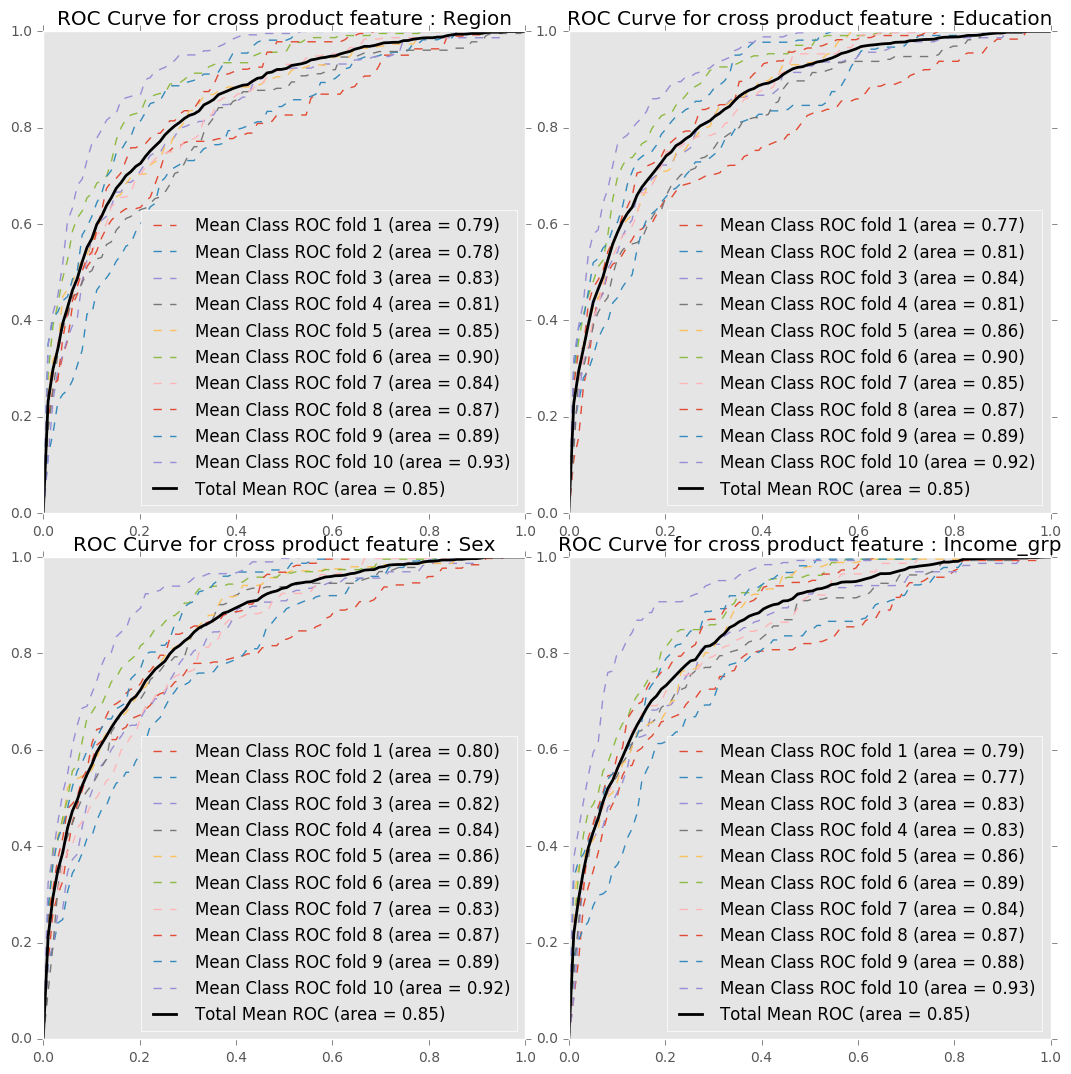

In [26]:
plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(4, 4)

ax1 = plt.subplot(gs[:2, :2])
ax1 = plt.title("ROC Curve for cross product feature : Region")
roc_1 = roc_clf(proba_=wd_region_proba)

ax2 = plt.subplot(gs[:2, -2:])
ax2 = plt.title("ROC Curve for cross product feature : Education")
roc_2 = roc_clf(proba_=wd_education_proba)

ax3 = plt.subplot(gs[-2:,:2])
ax3 = plt.title("ROC Curve for cross product feature : Sex")
v_clf_3 = roc_clf(proba_=wd_sex_proba)

ax4 = plt.subplot(gs[-2:,-2:])
ax4 = plt.title("ROC Curve for cross product feature : Income_grp")
v_clf_e = roc_clf(proba_=wd_income_grp_proba)

**The above four ROC plots display the model with  region + all the other categorical variables; educaiton + all the other categorical variables; sex + all the other categorical variables; and Income_grp + all the other categorical variables. But the overall performance is still similar in this case. Still, our conclusion is that in this dataset we do not have a significant important cross-product feature. **


**Another idea is that we can also treat the number of cross-product features as a hyper parameter, and we can tune it. Under this idea, we can add one, or two, or even P (P= number of the cross-product features) cross-product features into the Wide and the Deep learning model. And if the selected number is less than P, the cross-product features added into model will be randomly selected from the list.**

Below is output:

### 3.2.2 How many cross-product features should be included

**In many data set, we can creat hundreds of cross-product features, so the number of cross-product feature should be added in the model will be a problem.Here we can treat the number of cross-product features as a hyper parameter, and we can tune it.**

**We have 6 cross-product features totally, we set the number of cross product feature to 1,2,3,4, and then randomly select cross-product features from the total. Calculating out all the AUC,and use that to compare models. What we can improve here is for each fixed number of cross-product features, we draw it several times instead of just one times, this will give us more unbiased results, but it is very time consuming.**

Below is output:

In [27]:
wide_columns_Num1, deep_columns_Num1 = setup_wide_deep_columns(num_cross = 1, mode = 'num')
wide_columns_Num2, deep_columns_Num2 = setup_wide_deep_columns(num_cross = 2, mode = 'num')
wide_columns_Num3, deep_columns_Num3 = setup_wide_deep_columns(num_cross = 3, mode = 'num')
wide_columns_Num4, deep_columns_Num4 = setup_wide_deep_columns(num_cross = 4, mode = 'num')



clf_wd_1 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_Num1,
                        dnn_feature_columns=deep_columns_Num1,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_2 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_Num2,
                        dnn_feature_columns=deep_columns_Num3,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_3 = learn.DNNLinearCombinedClassifier(                    
                        linear_feature_columns=wide_columns_Num3,
                        dnn_feature_columns=deep_columns_education,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

clf_wd_4 = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns_Num4,
                        dnn_feature_columns=deep_columns_Num4,
                        dnn_hidden_units=[100, 50],
                        n_classes=4)

In [28]:
%%time

# calculate f1 scores for both networks
clf_1_f1 = []
clf_2_f1 = []
clf_3_f1 = []
clf_4_f1 = []

wd_1_proba = []
wd_2_proba = []
wd_3_proba = []
wd_4_proba = []


for k, (train, test) in enumerate(kfold):
    
    input_wrapper = lambda:process_input(df_train.iloc[train],'vote',categorical_headers, numeric_headers)
    output_wrapper = lambda:process_input(df_train.iloc[test],None,categorical_headers, numeric_headers)

    clf_wd_1.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_2.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_3.fit(input_fn=input_wrapper, steps=2000)
    clf_wd_4.fit(input_fn=input_wrapper, steps=2000)

    yhat_1 = clf_wd_1.predict(input_fn=output_wrapper)
    yhat_2 = clf_wd_2.predict(input_fn=output_wrapper)
    yhat_3 = clf_wd_3.predict(input_fn=output_wrapper)
    yhat_4 = clf_wd_4.predict(input_fn=output_wrapper)
    
    wd_proba_1 = clf_wd_1.predict_proba(input_fn=output_wrapper)
    wd_proba_2 = clf_wd_2.predict_proba(input_fn=output_wrapper)
    wd_proba_3 = clf_wd_3.predict_proba(input_fn=output_wrapper)
    wd_proba_4 = clf_wd_4.predict_proba(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    y_hat_1 = [x for x in yhat_1]
    y_hat_2 = [x for x in yhat_2]
    y_hat_3 = [x for x in yhat_3]
    y_hat_4 = [x for x in yhat_4]
    
    y_test = list(df_train.iloc[test].vote.values)
    
    wd_proba_1 = [x for x in wd_proba_1]
    wd_proba_1 = np.vstack(wd_proba_1)
    
    wd_proba_2 = [x for x in wd_proba_2]
    wd_proba_2 = np.vstack(wd_proba_2)
    
    wd_proba_3 = [x for x in wd_proba_3]
    wd_proba_3 = np.vstack(wd_proba_3)
    
    wd_proba_4 = [x for x in wd_proba_4]
    wd_proba_4 = np.vstack(wd_proba_4)
    
    external_f1_1 = f1_score(y_test, y_hat_1, average='micro')
    external_f1_2 = f1_score(y_test, y_hat_2, average='micro')
    external_f1_3 = f1_score(y_test, y_hat_3, average='micro')
    external_f1_4 = f1_score(y_test, y_hat_4, average='micro')
    
    clf_1_f1.append(external_f1_1)
    clf_2_f1.append(external_f1_2)
    clf_3_f1.append(external_f1_3)
    clf_4_f1.append(external_f1_4)
    
    wd_1_proba.append(wd_proba_1)
    wd_2_proba.append(wd_proba_2)
    wd_3_proba.append(wd_proba_3)
    wd_4_proba.append(wd_proba_4)
    

Wall time: 23min 19s


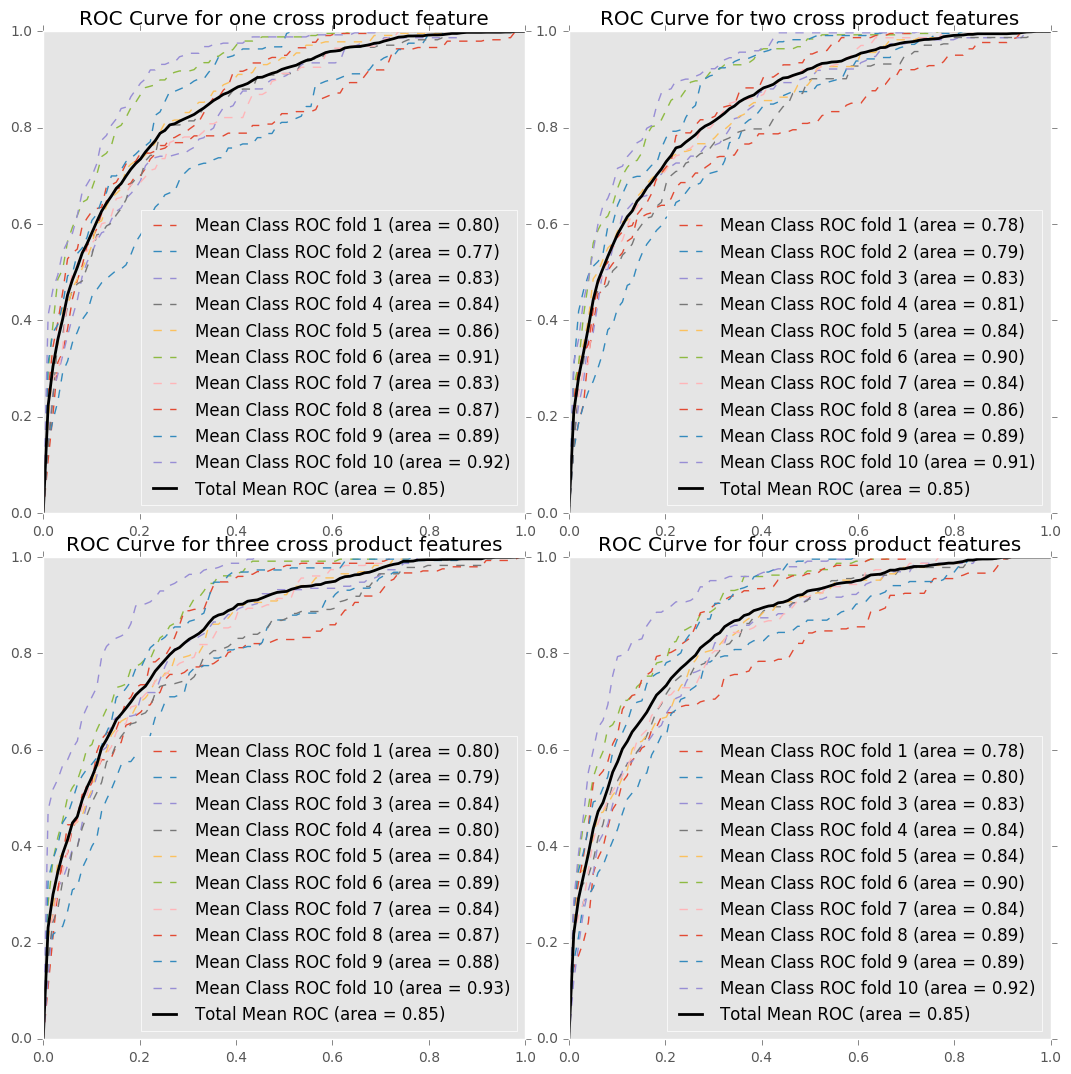

In [29]:
plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(4, 4)

ax1 = plt.subplot(gs[:2, :2])
ax1 = plt.title("ROC Curve for one cross product feature")
roc_1 = roc_clf(proba_=wd_1_proba)

ax2 = plt.subplot(gs[:2, -2:])
ax2 = plt.title("ROC Curve for two cross product features")
roc_2 = roc_clf(proba_=wd_2_proba)

ax3 = plt.subplot(gs[-2:,:2])
ax3 = plt.title("ROC Curve for three cross product features")
v_clf_3 = roc_clf(proba_=wd_3_proba)

ax4 = plt.subplot(gs[-2:,-2:])
ax4 = plt.title("ROC Curve for four cross product features")
v_clf_e = roc_clf(proba_=wd_4_proba)

**From the graph above, it has some evidence that adding more cross-product features would help the classification have a better performance. But by adding one cross-product feature each time, the performance only improves slightly. Therefore,in this case, adding more cross-product features do improve the model performance, but the improvement is not that significant. But our conclusion for our voting dataset still is that the cross-product features do not have very significant influence to the whole model.**

___
<a id="RE"></a>
<a href="#top">Back to Top</a>
## Reference

Scikit-Learn. Confution Matrix Visualization.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py (Accessed 3/30/2017)

Vincentarelbundock. Rdatasets. Voting Intentions in the 1988 Chilean Plebiscite.  
    http://vincentarelbundock.github.io/Rdatasets/datasets.html (Accessed 2/27/2017)

Wikipedia. Data dredging.
    https://en.wikipedia.org/wiki/Data_dredging (Accessed 2/27/2017)
    
Wikipedia. Chilean Natioanl Plebiscite, 1998
    https://en.wikipedia.org/wiki/Chilean_national_plebiscite,_1988#Plebiscite (Accessed 3/24/2017)

Data Science Stack Exchange. Micro Average vs Macro average Performance in a Multiclass classification setting.
    http://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001 (Accessed 3/23/2017)